# Chapter 16: Generalized Linear Madness

Thus far, we have learned a great deal about the GLM, which is a powerful framework for building statistical models. However, the GLM framework is not infinitely flexible, and as such, certain processes or phenomena may be outside our ability to model if we restrict ourselves to using GLM's. In this chapter we will explore more _bespoke_ statistical models inspired by actual scientific theories.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd "/home/ecotner/statistical-rethinking/"

/home/ecotner/statistical-rethinking


In [4]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.tensor as tt
import pyro
from pyro.distributions import (
    Beta,
    Binomial,
    Categorical,
    Dirichlet,
    Exponential,
    LogNormal,
    Normal,
    Poisson,
    Rejector,
)
from pyro.ops.stats import hpdi, quantile
from pyro.infer import Predictive
from torchdiffeq import odeint, odeint_adjoint
import arviz as az

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code/")
from utils import train_nuts, traceplot

### Code 16.1 - 16.3
Recall one of our very first regression analyses, where we attempted to predict height using weight with a simple linear model. There were some unsatisfying problems with it, such as the analysis only being valid for adults over 18, the causal implication that weight _causes_ height, etc. Now, we will try to do better and formulate a more scientifically-motivated model for predicting weight from height.

First, we assume that a person's volume is roughly cylindrical. This is obviously not true, but in the most approximate sense, it has the correct form. Recall the volume of a cylinder is $V = \pi r^2 h$, where $r$ and $h$ are the radius/height of the cylinder. We don't really know $r$, but let's just assume that it is some constant proportion of a person's height $r = ph$ (in order to maintain the typical shape of a human). We also assume that a person's weight is proportional to their volume $W = kV$. This implies the following simple model:

$$ W = \pi kp^2 h^3 $$

Now we need to turn this "scientific" model into a statistical model. We know that weight must be positive, so we should use some distribution that only has positive support, like the lognormal. The proportionality constants $k$ and $p$ must be strictly positive as well, so we will choose appropriate priors there as well. One important point is that due to the combination $\theta = kp^2$ occuring in the model definition, $k$ and $p$ cannot be independent of one another, and we may simply replace their product with $\theta$ in the model. However, then it becomes more difficult to choose appropriate priors, so we will leave them as is for now. For $p$, we know that nobody is wider than they are tall, so we can choose a prior that has the vast majority of its mass between 0 and 1/2. For $k$, we can either look up what this value typically is, or we can use some dimensional analysis (my favorite). If we use units where our data takes on a dimensionless value of 1 when we are at the average, then for an individual of average height and weight, $1 = \pi k p^2$, so k must be around $1/\pi p^2 \sim 2 - 5$ in these units.

In [9]:
df = pd.read_csv("data/Howell1.csv", sep=";")
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

In [10]:
data = {
    "height": tt((df["height"]/df["height"].mean()).values).double(),
    "weight": tt((df["weight"]/df["weight"].mean()).values).double(),
    "N": len(df),
}

In [39]:
def model_m16_1(data, training=False):
    # priors
    k = pyro.sample("k", LogNormal(tt(3.).log(), tt(0.5)))
    p = pyro.sample("p", Beta(2., 10.))
    σ = pyro.sample("σ", Exponential(1.))
    # observations
    with pyro.plate("obs", data["N"]):
        μ = torch.log(tt(3.14159) * k * (p**2) * (data["height"]**3))
        if training:
            pyro.sample("W", LogNormal(μ, σ), obs=data["weight"])
        else:
            return pyro.sample("W", LogNormal(μ, σ))

In [41]:
m16_1 = train_nuts(model_m16_1, data, 500, 1500)

Warmup:   0%|          | 0/2000 [00:00, ?it/s]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  
/home/ecotner/pyro/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore th

In [42]:
m16_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      4.14      1.87      3.70      1.64      6.87    343.81      1.01
         p      0.29      0.06      0.28      0.19      0.38    400.70      1.01
         σ      0.21      0.01      0.21      0.20      0.22    474.80      1.01

Number of divergences: 0


Let's take a look at the posterior distributions we learned; remember that $k$ and $p$ were non-identifiable, so the distributions learned were very narrow 1-D manifolds in $k$-$p$ space. In a more complex model, where $k$ and $p$ are functions of height or age, this might not hold true though. Note that the posterior predictive distribution tracks the data fairly well, except for the low-height, low-weight region of the distribution.

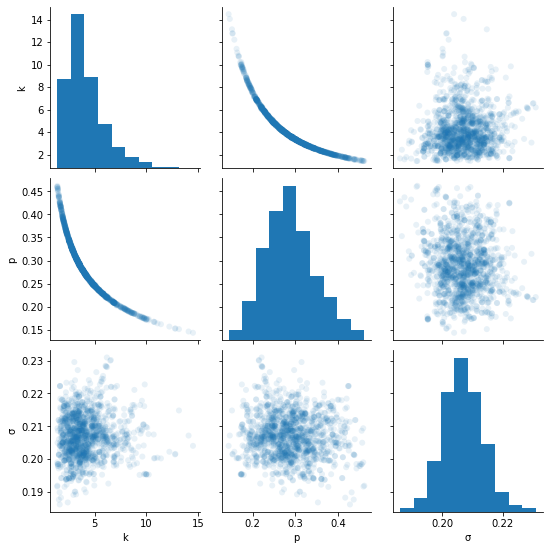

In [60]:
s = m16_1.get_samples()
sns.pairplot(
    pd.DataFrame(s),
    corner=False,
    kind="scatter",
    plot_kws=dict(alpha=0.1, edgecolor="none"),
)
plt.show()

Smaller, lighter individuals are also typically younger as well, and it is well-known that children grow at a much different rate than adults. Perhaps by taking age into account as well (and allowing it to influence $k$ and $p$) might lead to a better model. No doubt there are many logical improvements that can be made.

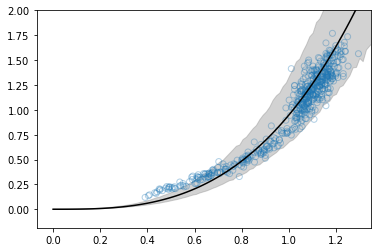

In [86]:
# plot data
h, w = [data[k] for k in ("height", "weight")]
plt.scatter(h, w, alpha=0.35, edgecolor="C0", facecolor="none")
# plot posterior regression line
h = torch.linspace(0, 1.4)
w = (3.14159*s["k"]*(s["p"]**2))[None,:]*(h[:,None]**3)
w_mean = w.mean(dim=1)
plt.plot(h, w_mean, color="black")
# plot posterior distribution of weights
d = {"height": h, "N": len(h)}
w = Predictive(model_m16_1, s, return_sites=("W",))(d)["W"]
w = quantile(w, [0.05, 0.95], dim=0)
plt.fill_between(h, *w, color="grey", alpha=0.35, zorder=-1)
plt.xlim(right=1.35)
plt.ylim(top=2.)
plt.show()

Finally, it is worth noting that our model, though it doesn't seem like a GLM, actually is (in disguise). Take the log of the weight, and you'll see that $\log(w_i)$ is a linear function of the log of height.

$$ \log(w_i) = \log(\pi k p^2 h_i^3) = \log(\pi) + \log(k) + 2\log(p) + 3\log(h_i) $$

The interesting thing about this linear model though is that our coefficient for $\log(h_i)$ is already chosen for us by theory (3). The only free parameter is the intercept.

### Code 16.4 - 16.8

Now we will explore the use of statistics to solve _inverse problems_, where we try to infer causes from observations. Our example will be a psychology experiment which aims to see what kind of strategies children possess for making decisions. In this experiment, 629 children ages 4-14 observed 4 other children choose among three different colored boxes, and then were offered the opportunity to make their own choice. In each trial, 3 of the demonstrators chose the same box, and the 4th chose a different one (this obviously must have been arranged beforehand). So one color was the majority choice, one was the minority choice, and the third was unchosen. How do we figure out whether these children are influenced by the majority?

In [4]:
box_df = pd.read_csv("data/Boxes.csv", sep=";")
box_df.head()

y  gender  age  majority_first  culture
0  1       1    6               0        2
1  3       1    8               0        2
2  2       2    8               1        2
3  1       1    6               0        2
4  2       1    5               1        2

The outcome `y` takes the values 1 (unchosen color), 2 (majority color), and 3 (minority color). The other variable we'll use for now is `majority_first`, which is a binary variable that indicates whether the majority color was demonstrated before the minority color. We want to use `y` to infer the strategies the children use to choose a color. The distribution contains 45% majority color choices:

In [5]:
box_df["y"].value_counts()/len(box_df)

2    0.456280
3    0.332273
1    0.211447
Name: y, dtype: float64

But that doesn't necessarily mean that 45% of children use the strategy of following the majority. There could be multiple strategies that end up having the same outcome. How do we tease out the different strategies, and what fraction of children use them?

Let's do a quick simulation where there are two strategies: half of the children pick randomly, and the other half follow the majority.

In [6]:
N = 30
# half are random
y1 = np.random.choice([1,2,3], size=N//2)
# other half follow majority
y2 = np.array((N//2)*[2])
# combine and shuffle
y = np.concatenate([y1, y2])
np.random.shuffle(y)
# count the 2's
(y==2).mean()

0.7

About 2/3 of the choices are for the majority color, but only half the children actually follow the majority. In reality, the scenario might be more complicated, with even more strategies. We will investigate 5 different ones:

1. Follow the majority
2. Follow the minority
3. Maverick: choose the color that no demonstrator chose
4. Random
5. Follow first: always copy the color that was demonstrated first

Each strategy is represented by a vector of probabilities, one for each color choice. For example, the majority strategy is $(0, 1, 0)$, minority is $(0, 0, 1)$, maverick is $(1, 0, 0)$, random is $(1/3, 1/3, 1/3)$. The only tricky one is the follow first strategy, because it is not a constant; it depends on the `majority_first` variable. If `majority_first==0`, then we have $(0, 0, 1)$; if `majority_first==1`, then it is $(0, 1, 0)$.

Now we need to make our model. Because the strategy probability vector's elements must sum to one, we need to enforce a simplex constraint on it. The easiest way to do that is with the Dirichlet prior distribution. (Recall the Dirichlet is the generalization of the Beta to multiple events). How do we express the likelihood? For each observed choice $y_i$, each strategy $s$ implies a probability of seeing $y_i$. The probability of seeing $y_i$ conditional on strategy $s$ is $P(y_i|s)$. The probability of a child with strategy $s$ is given by $p_s$, so the marginal probability of observing $y_i$ is

$$
P(y_i) = \sum_{s=1}^5 p_s P(y_i|s)
$$

The conditional probabilities $P(y_i|s)$ are determined logically (although not necessarily deterministically) by the definitions of the strategies 1-5.

Writing this in a more conventional form, we have

$$\begin{align*}
y_i &\sim \text{Categorical}(\theta) \\
\theta_j &= \sum_{s=1}^5 p_s P(j|s) \\
p &\sim \text{Dirichlet}([4,4,4,4,4])
\end{align*}$$

In [7]:
data = {
    "N": len(box_df),
    "y": tt(box_df["y"].values-1).long(),
    "majority_first": tt(box_df["majority_first"]).long(),
    "P(y|s)": tt([
        [ # if majority_first==0
            [0., 1., 0.], # majority
            [0., 0., 1.], # minority
            [1., 0., 0.], # maverick
            [1/3, 1/3, 1/3], # random
            [0., 0., 1.], # follow first
        ],[ # if majority_first==1
            [0., 1., 0.], # majority
            [0., 0., 1.], # minority
            [1., 0., 0.], # maverick
            [1/3, 1/3, 1/3], # random
            [0., 1., 0.], # follow first
        ]
    ]).double(),
}

In [8]:
def model_m16_2(data, training=False):
    # prior
    p = pyro.sample("p", Dirichlet(tt(5*[4.]))).double()
    # outcome probability
    P = data["P(y|s)"][data["majority_first"]] # vector of matrices...
    θ = torch.einsum("s,isj->ij", p, P)
    # sample outcome
    with pyro.plate("obs", data["N"]):
        if training:
            pyro.sample("y", Categorical(θ), obs=data["y"])
        else:
            return pyro.sample("y", Categorical(θ))

In [9]:
m16_2 = train_nuts(model_m16_2, data, 500, 3000)

Warmup:   0%|          | 0/3500 [00:00, ?it/s]/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ecotner/pyro/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Warmup:   0%|          | 1/3500 [00:00,  5.46it/s, step size=1.80e+00, acc. prob=1.00

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 3500/3500 [00:50, 69.88it/s, step size=3.25e-01, acc. prob=0.929]


In [10]:
m16_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      p[0]      0.26      0.04      0.26      0.20      0.32    846.03      1.00
      p[1]      0.14      0.03      0.14      0.09      0.19    880.29      1.00
      p[2]      0.15      0.03      0.15      0.10      0.20    890.66      1.00
      p[3]      0.20      0.08      0.19      0.07      0.33    640.57      1.00
      p[4]      0.26      0.03      0.26      0.21      0.31   2865.09      1.00

Number of divergences: 0


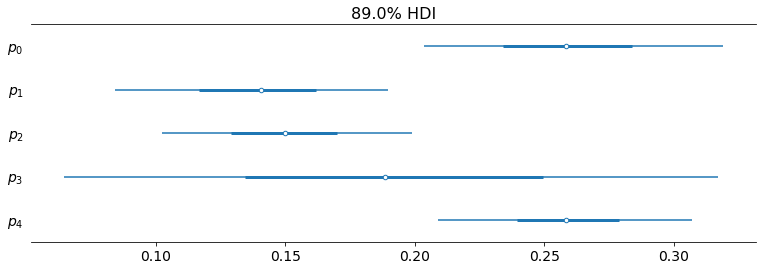

In [11]:
s = m16_2.get_samples(group_by_chain=True)
s = {fr"$p_{i}$": s["p"][...,i] for i in range(s["p"].shape[-1])}
fig, ax = plt.subplots(figsize=(13, 4))
az.plot_forest(s, ax=ax, kind="forestplot", hdi_prob=0.89)
plt.show()

We can see that even though 45% of the subjects chose the majority color, the model is fairly confident that only about 25% actually followed the majority _strategy_ ($p_0$). This is our first example of a _state space model_, which are a class of models that posit some hidden state (in this case, the child's strategy), that produces observations (in this case, the choice of color). When the states are discrete categories, the model may be called a Hidden Markov Model (HMM). Many time series models are state space models, since the true state of the time series is unobserved, only noisy measures.

### Code 16.9 - 16.12

We can also use Bayesian methods to help us figure out parameters of differential equations. Consider the following dataset of chimpanzees cracking nuts by using tools.

In [4]:
nut_df = pd.read_csv("data/Panda_nuts.csv", sep=";")
nut_df.head()

chimpanzee  age sex hammer  nuts_opened  seconds help
0          11    3   m      G            0     61.0    N
1          11    3   m      G            0     37.0    N
2          18    4   f   wood            0     20.0    N
3          18    4   f      G            0     14.0    y
4          18    4   f      L            0     13.0    N

We want to see how age influences the ability to crack nuts. For simplicity's sake, let's say that learning how to crack nuts is super easy, and so the main factor in nut cracking is how strong a chimpanzee is. Strength is related to mass, and mass increases with time. So there's our link (this is super-oversimplified logic, but let's just go with it for now). We assume that there is some maximum mass for chimpanzees, so the relation between age and mass is definitely non-linear. A typical model of growth is given by the differential equation

$$ \frac{dM}{dt} = k(M_\text{max} - M) $$

where $k$ is some growth rate. This implies exponential growth when mass is small, that then eventually tapers off to no growth when $M$ approaches $M_\text{max}$. In general, most differential equations do not have simple (or even analytic) solutions, but fortunately this one does:

$$ M_t = M_\text{max} \left(1 - \exp\left(-kt\right)\right) $$

Next, we postulate that strength is simply proportional to mass: $S_t = \beta M_t$. Now we need a way to relate strength to the rate of nut cracking. We could say that $S_t$ is proportional to some rate, but consider that there are multiple ways in which strength helps nut cracking. First, more strength allows a chimpanzee to lift a heavier hammer, which can come down on a nut with more momentum. Second, they can also add additional force to the hammer on the downswing. Third, stronger/larger animals tend to have longer limbs, which means they can lift the hammer higher in the first place. So we expect that strength contributes to nut cracking rate with a greater than linear effect: $\dot{n} = \alpha S_t^\theta$ where $\theta$ is assumed greater than one. Altogether, this gives us the relationship

$$ \dot{n} = \alpha\left(\beta M_\text{max}\left(1 - \exp(-kt)\right)\right)^\theta $$

However, we know that the multiplicative combination of parameters $\alpha(\beta M_\text{max})^\theta$ is non-identifiable, so we can simply replace them with a single parameter $\phi$, which has units of nuts/second. Finally, we can multiply this by the duration/exposure of each nut-cracking session $d$ to get the dimensionless Poisson $\lambda$ parameter. Our statistical model is then

$$\begin{align*}
n_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= d_i \phi \left(1 - \exp(-kt_i)\right)^\theta
\end{align*}$$

What about priors? A chimpanzee reaches adult mass around 12 years of age, we need prior growth curves to plateau around $t = 12$ years. we also need distributions for $k$ and $\theta$ that accomplish this. And then the prior for $\phi$ should have a mean around the maximum rate for nut cracking. Let's suppose a professional chimpanzee could open about 1 nut/second.

In [6]:
data = {
    "N": len(nut_df),
    "age": tt(nut_df["age"].values).double(),
    "nuts_opened": tt(nut_df["nuts_opened"].values).double(),
    "duration": tt(nut_df["seconds"].values).double(),
}

In [93]:
def model_m16_3(data, training=False):
    # priors
    φ = pyro.sample("φ", LogNormal(tt(1.).log(), 0.1))
    k = pyro.sample("k", LogNormal(tt(0.25).log(), 0.25))
    θ = pyro.sample("θ", LogNormal(tt(8.).log(), 0.25))
    # observations
    d, t = [data[key] for key in ("duration", "age")]
    with pyro.plate("obs", data["N"]):
        λ = d * φ * (1 - torch.exp(-k*t))**θ
        if training:
            pyro.sample("nuts", Poisson(λ), obs=data["nuts_opened"])
        else:
            return pyro.sample("nuts", Poisson(λ))

Before running inference, let's visualize the growth curves determined by the prior distributions:

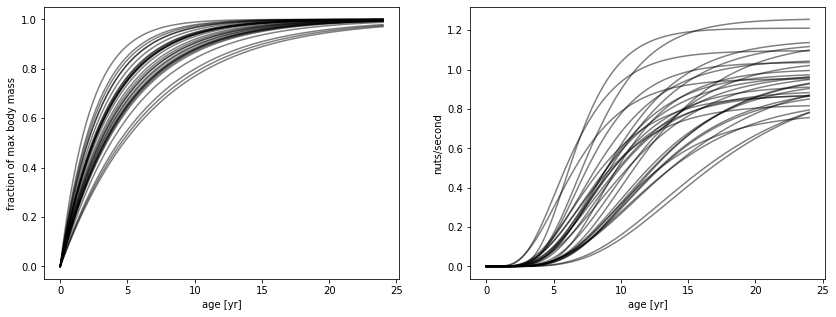

In [100]:
d = {"N": 100, "age": torch.linspace(0, 24, 100), "duration": torch.ones(100)}
s = Predictive(model_m16_3, {}, num_samples=30, return_sites=["φ","k","θ"])(d)
s = {k: v.squeeze() for k, v in s.items()}
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
# plot body mass
plt.sca(axes[0])
mass = 1 - torch.exp(-s["k"][:,None]*d["age"][None,:])
for i in range(len(mass)):
    plt.plot(d["age"], mass[i], color="black", alpha=0.5)
plt.xlabel("age [yr]")
plt.ylabel("fraction of max body mass")
# plot nuts/sec
plt.sca(axes[1])
nuts_per_sec = s["φ"][:,None] * (mass**(s["θ"][:,None]))
for i in range(len(nuts_per_sec)):
    plt.plot(d["age"], nuts_per_sec[i], color="black", alpha=0.5)
plt.xlabel("age [yr]")
plt.ylabel("nuts/second")
plt.show()

In [98]:
m16_3 = train_nuts(model_m16_3, data, 1000, 3000)

Warmup:   0%|          | 0/4000 [00:00, ?it/s]/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  after removing the cwd from sys.path.
/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: Trac

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 4000/4000 [01:13, 54.50it/s, step size=1.86e-01, acc. prob=0.922]


In [99]:
m16_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         φ      0.83      0.04      0.83      0.78      0.89   1026.48      1.00
         k      0.45      0.04      0.45      0.40      0.51    705.22      1.00
         θ     15.83      3.23     15.51     10.84     20.99    757.32      1.00

Number of divergences: 0


Now let's look at what the posteriors have learned for the growth curves.

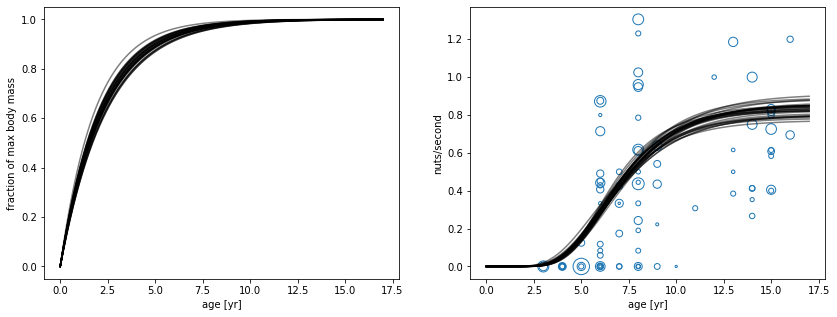

In [113]:
d = {"N": 100, "age": torch.linspace(0, 17, 100), "duration": torch.ones(100)}
s = m16_3.get_samples()
idx = np.random.choice(len(s["k"]), size=30, replace=False)
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
# plot body mass
plt.sca(axes[0])
mass = 1 - torch.exp(-s["k"][:,None]*d["age"][None,:])
for i in idx:
    plt.plot(d["age"], mass[i], color="black", alpha=0.5)
plt.xlabel("age [yr]")
plt.ylabel("fraction of max body mass")
# plot nuts/sec posterior regression lines
plt.sca(axes[1])
nuts_per_sec = s["φ"][:,None] * (mass**(s["θ"][:,None]))
for i in idx:
    plt.plot(d["age"], nuts_per_sec[i], color="black", alpha=0.5)
# plot data
plt.scatter(
    x=data["age"],
    y=data["nuts_opened"]/data["duration"],
    s=2*data["duration"],
    facecolor="none",
    edgecolor="C0"
)
plt.xlabel("age [yr]")
plt.ylabel("nuts/second")
plt.show()

Like I said before, this model is overly simplistic. We can extend it to take into account covariates like sex and the identity of the individual who is doing the cracking. When doing grouping, it is important to note that some variables, like $\theta$ are dependent on physics, not the individual. We might also consider that the nut-cracking process is zero-inflated, or that there are already detailed studies of chimpanzee growth curves that we can repurpose for our model.

### Code 16.13 - 16.??
We can also use our scientific knowledge to help us model _time series_, where we have one (or many) sequences that evolve through time. We saw a very simplistic spline-based time series regression (of cherry blossom blooms, I believe) in one of the earlier chapters. That model was kind of naiive and we weren't able to make use of any domain expertise to help refine it. Here, we will use models of population dynamics to study the gathering of lynx/hare pelts, and the populations underlying them.

In [10]:
lynx_hare_df = pd.read_csv("data/Lynx_Hare.csv", sep=";")
lynx_hare_df.head()

Year  Lynx  Hare
0  1900   4.0  30.0
1  1901   6.1  47.2
2  1902   9.8  70.2
3  1903  35.2  77.4
4  1904  59.4  36.3

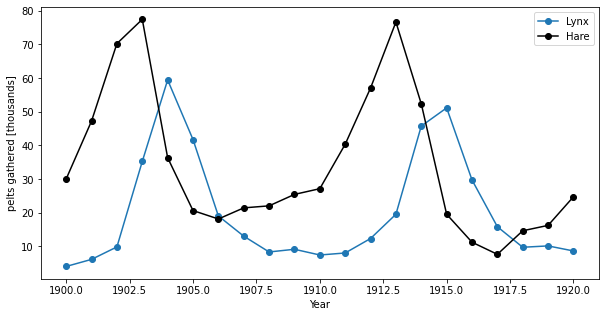

In [11]:
df = lynx_hare_df
plt.figure(figsize=(10, 5))
plt.plot(df["Year"], df["Lynx"], color="C0", marker="o", label="Lynx")
plt.plot(df["Year"], df["Hare"], color="black", marker="o", label="Hare")
plt.xlabel("Year")
plt.ylabel("pelts gathered [thousands]")
plt.legend()
plt.show()

A common way to model time series is through an _autoregressive_ model (i.e. you regress points in the future on points in the past through a linear regression). The most basic model would be something like

$$ E(H_t) = \alpha + \beta_1 H_{t-1} $$

where the average value of the hare population at time $t$ depends on the population at time $t-1$. If $\beta_1 < 1$, then the population eventually settles around $\alpha/(1-\beta_1)$ (when $H_t = H_{t-1}$). We can also add terms that depend on the predator (or any covariate, really)

$$ E(H_t) = \alpha + \beta_1 H_{t-1} + \beta_2 L_{t-1} $$

or even add deeper lags

$$ E(H_t) = \alpha + \beta_1 H_{t-1} + \beta_2 L_{t-1} + \beta_3 H_{t-2} $$

Autoregressive techniques are ubiquitous; they have been used to model pretty much everything under the sun. But there are some philosophical problems with them. First, there is nothing that happened two time periods ago that influenced the current time period, except through its influence on the state of the system one time period ago. So no lag beyond one makes any causal sense. Second, if the state of the system, $H_t$ and $L_t$ are measured with error, then the model is propagating error. It isn't the _observed_ $H_{t-1}$ that influences $H_t$, but the real _unobserved_ $H_{t-1}$. These kinds of problems are rectified with a _state space_ model. Third, an autoregressive model usually has no direct interpretation of the parameters you've learned. In the very first model above, if there are zero hares in the previous timestep $H_{t-1} = 0$, then in the next time step there are $H_t = \alpha$, which is nonsense.

Many processes in physics, chemistry, economics, ecology, etc. can be modeled with differential equations, which relate the quantities of interest to their rate of change (through either time or space, or both... or even more abstract dimensions). Let's make a differential equation for our lynx-hare dynamical system. It is obviously true that

$$ \frac{dH}{dt} = H\text{(birth rate)} - H\text{(death rate)} $$

The simplest ecological model assumes constant birth/death rates. This implies that $\dot{H} = H(b_H - m_H)$, where $b_H$/$m_H$ are the hare's birth/mortality rates. But we know that the hare death rate actually depends on the lynx population (perhaps linearly?), and the lynx birth rate depends on the hare population:

$$
\frac{dH}{dt} = H(b_H - m_H L) \\
\frac{dL}{dt} = L(b_L H - m_L)
$$

This isn't super-realistic, because the hare's source of food might be variable as well, and lynxes prey on more than hares. But it will be good enough for now. It is also very widely acclaimed - it goes by the name of the _Lotka-Volterra_ model. We can learn a lot about the system even without any data. For example, it produces cycles of population boom/bust, where the predator population lags behind the prey population (i.e. the predator boom comes _after_ the prey boom, and the predator bust comes _after_ the prey bust), as seen in the plot above.

We can numerically simulate solutions to this equation by using any number of techniques. The simplest one is called the [_Euler method_](https://en.wikipedia.org/wiki/Euler_method), and involves replacing derivatives with finite differences like $dH/dt \rightarrow (H_{t} - H_{t-1})/\Delta t$, then solving for $H_{t}$ as a function of lag variables. More advanced ones like [_Runge-Kutta_](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) use a series of interleaved fractional updates to reduce the error accrued with each integration step. There are other specialized techniques like [_Verlet integration_](https://en.wikipedia.org/wiki/Verlet_integration) that is useful in physics simulations that need to conserve energy, and [_spectral methods_](https://en.wikipedia.org/wiki/Spectral_method) for solving diffusion equations. `scipy` has a lot of these [advanced solvers](https://docs.scipy.org/doc/scipy/reference/integrate.html#solving-initial-value-problems-for-ode-systems) built in. However, since we're going for simple, we'll just use the Euler method for now.

In [6]:
def sim_lynx_hare(n_steps, init, theta, dt=0.002):
    """Simulates lynx-hare population using Euler method
    
    Arguments:
        n_steps (int): number of integration steps to take
        init (tuple(float, float)): initial (lynx, hare) populations
        theta (tuple(float, ...)): 4-element tuple containing parameters of lynx/hare
            birth/mortality rates
        dt (float): size of integration step
    """
    L = np.empty(n_steps)
    H = np.empty(n_steps)
    L[0] = init[0]
    H[0] = init[1]
    for i in range(1, n_steps):
        H[i] = H[i-1] + dt*H[i-1]*(theta[0] - theta[1]*L[i-1])
        L[i] = L[i-1] + dt*L[i-1]*(theta[2]*H[i-1] - theta[3])
    return L, H

In [54]:
theta = (0.5, 0.05, 0.025, 0.5)
init = lynx_hare_df[["Lynx", "Hare"]].iloc[0].values
%timeit sim_lynx_hare(10_000, init, theta, dt=0.002)

15.8 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# try same thing using `torchdiffeq` package
theta = tt([0.5, 0.05, 0.025, 0.5])
θ1 = tt([-theta[3], theta[0]])
θ2 = tt([theta[2], -theta[1]])
def sim_lynx_hare_3(t, y):
    return θ1*y + θ2*y.prod()

t = torch.linspace(0, 20, 10000)
%timeit odeint(sim_lynx_hare_3, tt(init), t, method="euler")

653 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
t = torch.linspace(0, 20, 10000)
z2 = odeint(sim_lynx_hare_3, tt(init), t, method="euler")

Here we see a comparison of our theoretical population simulation to the observed number of pelts (which if you recall is just a noisy observation of the population). The general shape of the theoretical curve is similar to that of the data, but the peaks are in the wrong place and not as high as they should be, the timescale seems a bit too long, etc. This is simply because we have just chosen some random parameters in our `theta` vector. If only we could use the data we have to choose better values of the birth/mortality parameters!

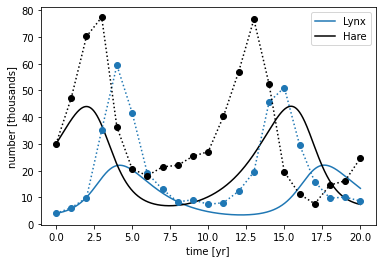

In [52]:
t = 0.002*np.arange(10000)
plt.plot(t, z2[...,0], color="C0", label="Lynx")
plt.plot(t, z2[...,1], color="black", label="Hare")
df = lynx_hare_df
t = df["Year"] - df["Year"].min()
plt.plot(t, df["Lynx"], color="C0", marker="o", linestyle=":")
plt.plot(t, df["Hare"], color="black", marker="o", linestyle=":")
plt.xlabel("time [yr]")
plt.ylabel("number [thousands]")
plt.legend()
plt.show()

Well, we can, of course. We just need to 1) connect our deterministic population dynamic model to our noisy observed data, and 2) ensure that the integration method we use to solve our ODE is differentiable (so that HMC can calculate gradients through it with respect to our model parameters). To solve the first problem, we introduce $h_t$ and $\ell_t$, which represent the _observed_ numbers of hares/lynx. While $H_t$ causes $H_{t+dt}$, the observed $h_t$ does not cause anything; it is just a noisy tracer of the unobserved state of the system at time $t$. We need to link $h_t$ back to $H_t$ so that we can do inference, which means we need to think about how $h_t$ is generated from $H_t$. Suppose that each hare is trapped with some probability $p_H$ (which likely varies from year to year, but we'll take as constant for now), and the actual number of pelts is rounded to the nearest 100 and divided by 1000, so they are no longer counts anymore. Let's simulate the trapping process for a single timestep:

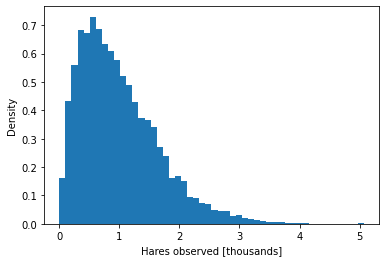

In [9]:
N = 10_000
H = 10_000
p = Beta(2., 18.).sample([N])
h = Binomial(H, p).sample()
h = torch.round(h)/1000
plt.hist(h, bins=50, density=True)
plt.xlabel("Hares observed [thousands]")
plt.ylabel("Density")
plt.show()

This looks pretty similar to a lognormal distribution; we could simply link the observed counts to the unobserved state like

$$
h_t \sim \text{LogNormal}(\log(p_H H_t), \sigma_H) \\
\ell_t \sim \text{LogNormal}(\log(p_L L_t), \sigma_L)
$$

and then the rest of the model follows as such:

$$\begin{align*}
H_0 &\sim \text{LogNormal}(\log 10, 1) \\
L_0 &\sim \text{LogNormal}(\log 10, 1) \\
H_{t>0} &= H_0 + \int_0^t d\tau\, H_\tau(b_H - m_H L_\tau) \\
L_{t>0} &= L_0 + \int_0^t d\tau\, L_\tau(b_L H_\tau - m_L)
\end{align*}$$

I won't waste space by listing out the priors, you can see them in the code below.

In [12]:
df = lynx_hare_df.sort_values("Year", ascending=True)
data = {
    "N": len(df),
    "n_steps": 50, # number of integration steps to do between each observation period
    "lynx": tt(df["Lynx"].values).double(),
    "hare": tt(df["Hare"].values).double(),
    "t": tt(df["Year"].values).double(),
}
data["dt"] = (data["t"][-1] - data["t"][0])/((data["N"]-1)*data["n_steps"])

# pyro doesn't have a built-in truncated normal distribution!
class TruncatedNormal(Rejector):
    def __init__(self, loc, scale, cutoff=0., validate_args=None):
        dist = Normal(loc, scale, validate_args)
        self.cutoff = tt(cutoff)
        log_prob_accept = lambda x: (x>cutoff).to(x.dtype).log()
        loc_scale = (1.-dist.cdf(cutoff)).log()
        super(TruncatedNormal, self).__init__(
            dist,
            log_prob_accept=log_prob_accept,
            log_scale=loc_scale,
        )
    
    @property
    def support(self):
        return torch.distributions.constraints.greater_than_eq(self.cutoff)

In [13]:
def int_lynx_hare_model(H0, L0, bH, bL, mH, mL, n_steps):
    θ1 = torch.cat([-mL.reshape(1), bH.reshape(1)])
    θ2 = torch.cat([bL.reshape(1), -mH.reshape(1)])
    def lynx_hare_model(t, y):
        return θ1*y + θ2*(y.prod())
    t = torch.linspace(0, 20, 21*n_steps)
    y0 = torch.cat([L0.reshape(1), H0.reshape(1)])
    y = odeint(lynx_hare_model, y0, t, method=None)
    return y[::n_steps]

In [86]:
def model_m16_4(data, training=False):
    # priors
    σH = pyro.sample("σH", Exponential(10.))
    σL = pyro.sample("σL", Exponential(10.))
    pH = pyro.sample("pH", Beta(2., 18.))
    pL = pyro.sample("pL", Beta(2., 18.))
    bH = pyro.sample("bH", TruncatedNormal(1., 0.05))
    bL = pyro.sample("bL", TruncatedNormal(0.05, 0.05))
    mH = pyro.sample("mH", TruncatedNormal(0.05, 0.05))
    mL = pyro.sample("mL", TruncatedNormal(1., 0.5))
    # integrate the ODE
    H0 = pyro.sample("H0", LogNormal(np.log(10.), 1.)).double()
    L0 = pyro.sample("L0", LogNormal(np.log(10.), 1.)).double()
    LH = int_lynx_hare_model(H0, L0, bH, bL, mH, mL, data["n_steps"])
    L = pyro.deterministic("L", LH[:,0])
    H = pyro.deterministic("H", LH[:,1])
    # emit observations
    with pyro.plate("obs", data["N"]):
        if training:
            h = pyro.sample("h", LogNormal((pH*H).log(), σH), obs=data["hare"])
            l = pyro.sample("l", LogNormal((pL*L).log(), σL), obs=data["lynx"])
        else:
            h = pyro.sample("h", LogNormal((pH*H).log(), σH))
            l = pyro.sample("l", LogNormal((pL*L).log(), σL))
            return h, l

If we look at the priors for this model, we can see that they are kind of all over the place, with very large excursions commonplace. Hopefully we can learn some parameters that make more sense.

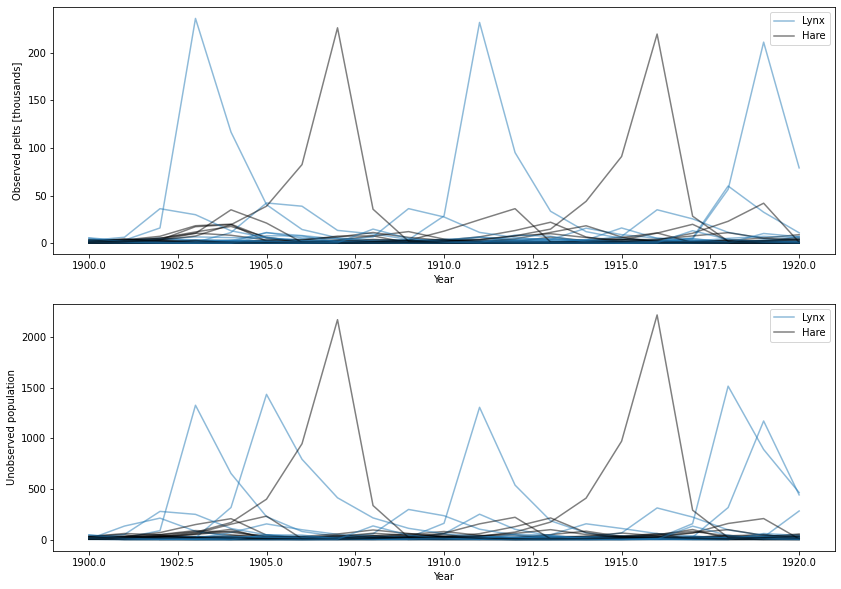

In [184]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 10))
idx = np.random.choice(3000, size=20, replace=False)
# s = {k: v[idx] for k, v in m16_4.get_samples().items()}
# cond_model = pyro.condition(model_m16_4, data={"bH": tt(1.), "mH": tt(0.05), "bL": tt(0.05), "mL": tt(1.)})
s = {k: v.squeeze() for k, v in Predictive(model_m16_4, {}, num_samples=30, return_sites=("H", "L", "h", "l"))(data).items()}
# plot observed pelt trajectories
plt.sca(axes[0])
for i in range(len(idx)):
    plt.plot(data["t"], s["l"][i], color="C0", alpha=0.5)
    plt.plot(data["t"], s["h"][i], color="black", alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Observed pelts [thousands]")
# plot unobserved population trajectories
plt.sca(axes[1])
for i in range(len(idx)):
    plt.plot(data["t"], s["L"][i], color="C0", alpha=0.5)
    plt.plot(data["t"], s["H"][i], color="black", alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Unobserved population")
for ax in axes:
    plt.sca(ax)
    plt.plot([], [], color="C0", alpha=0.5, label="Lynx")
    plt.plot([], [], color="black", alpha=0.5, label="Hare")
    plt.legend()
plt.show()

In [96]:
m16_4 = train_nuts(
    model_m16_4, data, 500, 3000, jit_compile=False, target_accept_prob=0.95,
    max_tree_depth=3, full_mass=True, adapt_mass_matrix=True, step_size=1e-5
)

Warmup:   0%|          | 0/3500 [00:00, ?it/s]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False, 'target_accept_prob': 0.95, 'max_tree_depth': 3, 'full_mass': True, 'step_size': 1e-05}


Sample: 100%|██████████| 3500/3500 [3:16:21,  3.37s/it, step size=3.69e-01, acc. prob=0.944]


In [104]:
m16_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        σH      0.29      0.05      0.28      0.20      0.37   1662.04      1.00
        σL      0.29      0.05      0.28      0.20      0.37   1631.61      1.00
        pH      0.24      0.08      0.23      0.11      0.37   1298.89      1.00
        pL      0.20      0.08      0.20      0.08      0.33   1428.74      1.00
        bH      0.92      0.05      0.92      0.84      1.01   1802.53      1.00
        bL      0.00      0.00      0.00      0.00      0.01   1261.81      1.00
        mH      0.01      0.00      0.01      0.00      0.02   1550.93      1.00
        mL      0.54      0.04      0.54      0.48      0.60   1561.20      1.00
        H0    151.75     63.85    137.19     68.17    240.51    871.54      1.00
        L0     42.54     20.48     37.43     15.84     68.36   1453.47      1.00

Number of divergences: 0


Wow, that took forever. Apparently differentiating through an ODE isn't terribly efficient. I found that it seemed to go faster if using a full mass matrix rather than just diagonal, and limited the tree depth (not exactly sure what this is) to reduce computation. However, the results are pretty good! There is strong agreement of the data with the posterior predictive for observed pelts. And since it is a generative model, we also have access to the underlying hidden state that shows what the unobserved population might be.

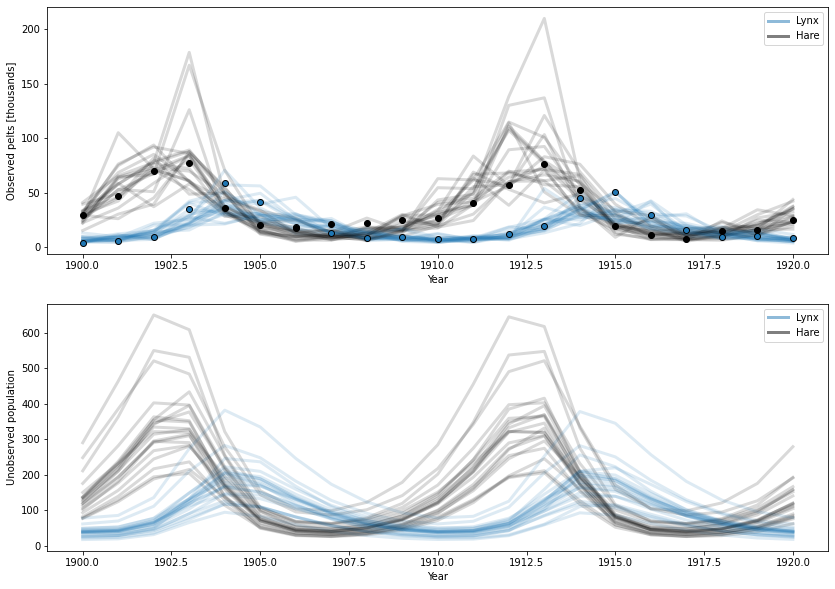

In [114]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 10))
idx = np.random.choice(3000, size=20, replace=False)
s = {k: v[idx] for k, v in m16_4.get_samples().items()}
# cond_model = pyro.condition(model_m16_4, data={"bH": tt(1.), "mH": tt(0.05), "bL": tt(0.05), "mL": tt(1.)})
s = {k: v.squeeze() for k, v in Predictive(model_m16_4, s, return_sites=("H", "L", "h", "l"))(data).items()}
# plot observed pelt trajectories
plt.sca(axes[0])
for i in range(len(idx)):
    plt.plot(data["t"], s["l"][i], color="C0", alpha=0.15, linewidth=3)
    plt.plot(data["t"], s["h"][i], color="black", alpha=0.15, linewidth=3)
# plot the observed data
plt.scatter(data["t"], data["lynx"], facecolor="C0", edgecolor="black", zorder=1000)
plt.scatter(data["t"], data["hare"], color="black", zorder=1000)
plt.xlabel("Year")
plt.ylabel("Observed pelts [thousands]")
# plot unobserved population trajectories
plt.sca(axes[1])
for i in range(len(idx)):
    plt.plot(data["t"], s["L"][i], color="C0", alpha=0.15, linewidth=3)
    plt.plot(data["t"], s["H"][i], color="black", alpha=0.15, linewidth=3)
for ax in axes:
    plt.sca(ax)
    plt.plot([], [], color="C0", label="Lynx", alpha=0.5, linewidth=3)
    plt.plot([], [], color="black", label="Hare", alpha=0.5, linewidth=3)
    plt.legend()
plt.xlabel("Year")
plt.ylabel("Unobserved population")
plt.show()

If we look at the pair plot for all the learned parameters, we can see some interesting relationships. Most parameters are uncorrelated or approximately so, but there are a few combinations which show very interesting correlations!

* $p_H$, $b_L$ and $H_0$: since only the product $p_H H$ is observable, if you increase one, you must decrease the other to keep the product constant. This explains why the scatterplot has that 1/x type behavior. the product $b_L H$ influences the evolution of the hidden state for $H$, not just $b_L$ alone. It seems that since $H_0$ sets the "scale" of the hare model, it is somewhat arbitrary. The same thing can be said for $p_L$, $m_H$ and $L_0$.
* $b_H$ and $m_L$: this has a strong negative correlation. If you increse the birth rate of hares, then you probably must decrease the mortality rate of lynxes so that the populations stay the same.
* $L_0$ and $H_0$: it seems that these have a mild negative correlation, but this is probably because high values for both are ruled out, otherwise we would observe many more pelts than we have data for.

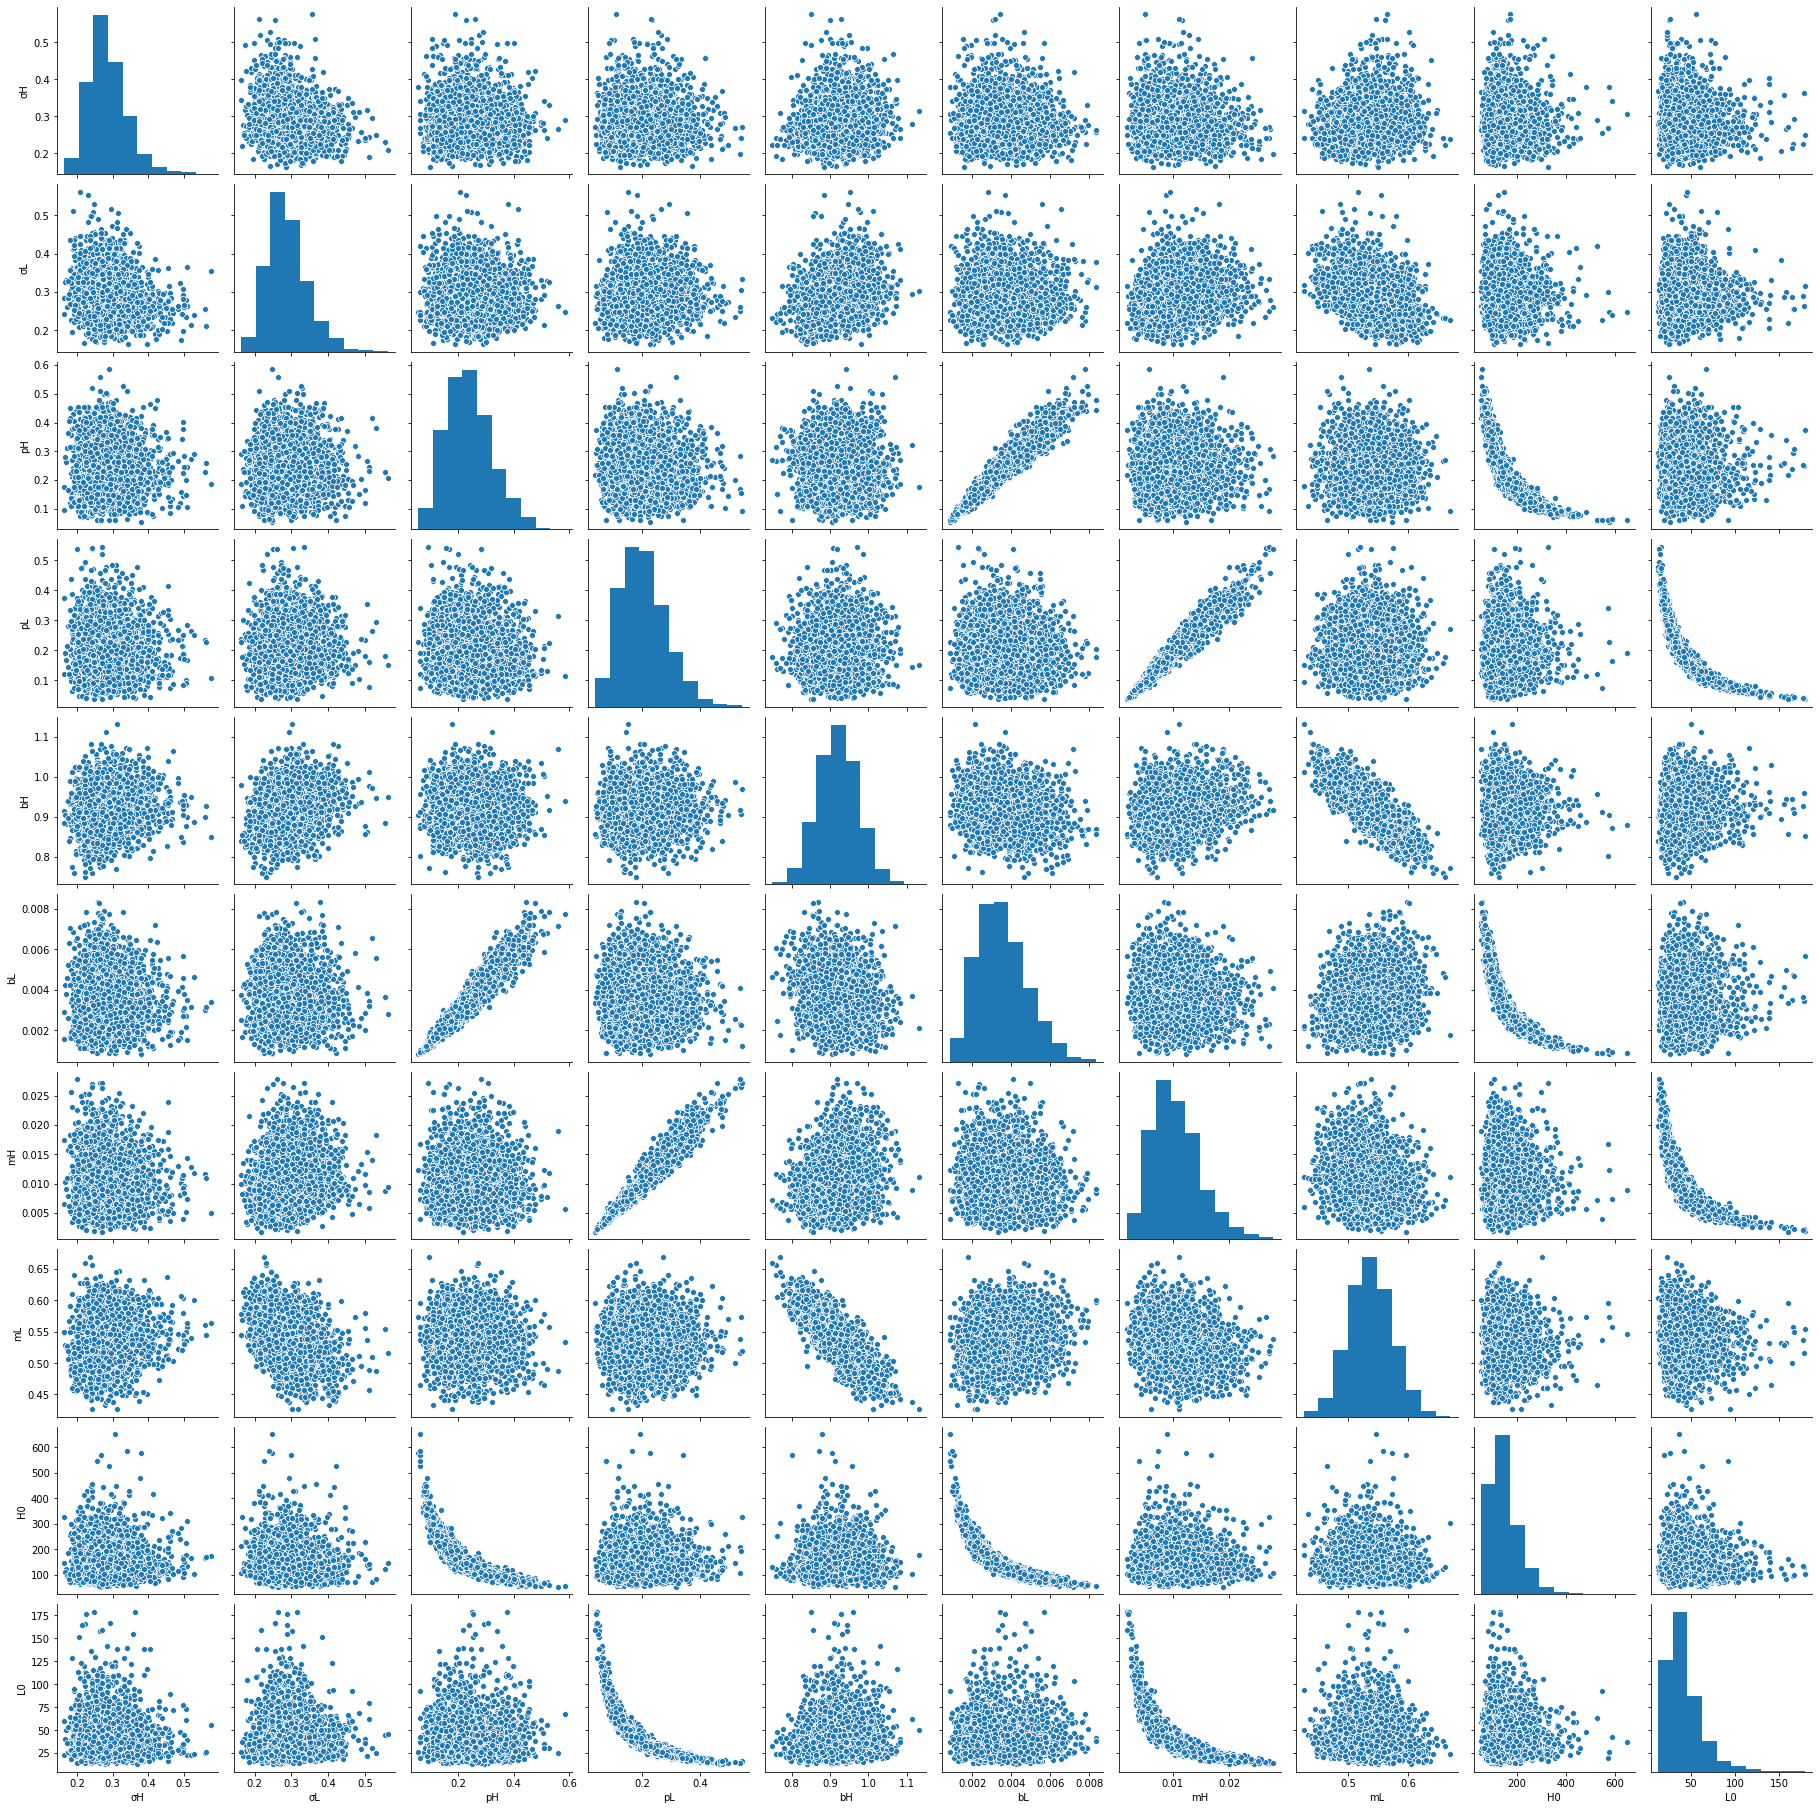

In [119]:
df = pd.DataFrame(m16_4.get_samples())
sns.pairplot(df)
plt.show()

### Bonus!

It seems that there are definitely issues of identifiability, probably related to the scale of the populations. If we try to non-dimensionalize the equations for the evolution of the hidden state, perhaps we can reduce this problem and make computation easier (this comes up all the time in physics simulations). Consider what happens if you decompose the population variables into $H(t) = H_0 \tilde{H}(t)$ and $L(t) = L_0 \tilde{L}$. Now your dynamical variables are $\tilde{H}$ and $\tilde{L}$, with initial conditions $\tilde{H}(0) = \tilde{L}(0) = 1$. Much simpler, right? What happens to your differential equations?

$$
H_0 \dot{\tilde{H}} = H_0 \tilde{H} \left(b_H - m_H L_0 \tilde{L}\right) \\
L_0 \dot{\tilde{L}} = L_0 \tilde{L} \left(b_L H_0 \tilde{H} - m_L\right)
$$

After some cancellations, this reduces to

$$
\dot{\tilde{H}} = \tilde{H} \left(b_H - \tilde{m}_H \tilde{L}\right) \\
\dot{\tilde{L}} = \tilde{L} \left(\tilde{b}_L \tilde{H} - m_L\right)
$$

where $\tilde{m}_H = m_H L_0$ and $\tilde{b}_L = b_L H_0$. You might think that this has accomplished nothing, because the equations look pretty much the same in structure, the only difference is the "names" of the variables. However, we have actually managed to eliminate two parameters from the system, $H_0$ and $L_0$, and replaced them with the immutable constant $1$. You might also notice that $b_H$ and $\tilde{m}_H$ are on roughly the same scale now ($0.9$ and $0.01*50=0.5$), whereas $b_H$ and $m_H$ were over an order of magnitude off from each other. (The same goes for $\tilde{b}_L$/$m_L$.) This is one of the advantages of non-dimensionalization - it usually makes most parameters O(1) if you do it properly, and therefore much easier to make priors for. After the ODE has been solved/integrated, then we can just multiply/divide by $H_0$/$L_0$ after the fact. We could also replace the quantities ($p_H H$, $p_L L$) with ($h_0 \tilde{H}$, $\ell_0 \tilde{L}$), where $h_0$ and $\ell_0$ are the initial observed pelts. In this way, we have completely eliminated $H_0$ and $L_0$ from the problem completely, while simultaneously revealing that it is only the combinations ($p_H H$, $p_L L$) that are observable, and not ($H$, $L$) directly.

Sometimes it also makes sense to non-dimensionalize the time variable like $t \rightarrow T\tau$, where $T$ is the length of the integration period (so that $\tau \in [0, 1]$), but it is probably not necessary here since the units of $t$ are such that $T$ is already fairly close to $O(1)$. Also, I think using the default Runge-Kutta ODE solver is overkill for such a simple problem, so we can also use the Euler method to speed things up.

In [14]:
def int_lynx_hare_model_dimless(bH, bL, mH, mL, n_steps):
    θ1 = torch.cat([-mL.reshape(1), bH.reshape(1)])
    θ2 = torch.cat([bL.reshape(1), -mH.reshape(1)])
    def lynx_hare_model(t, y):
        return θ1*y + θ2*(y.prod())
    t = torch.linspace(0, 20, 21*n_steps)
    y0 = tt([1., 1.])
    y = odeint(lynx_hare_model, y0, t, method="euler")
    return y[::n_steps]

In [76]:
def model_m16_4x(data, training=False):
    # priors
    σH = pyro.sample("σH", Exponential(10.))
    σL = pyro.sample("σL", Exponential(10.))
    bH = pyro.sample("bH", TruncatedNormal(1., 0.75))
    bL = pyro.sample("bL", TruncatedNormal(1., 0.75))
    mH = pyro.sample("mH", TruncatedNormal(1., 0.75))
    mL = pyro.sample("mL", TruncatedNormal(1., 0.75))
    # integrate the ODE
    LH = int_lynx_hare_model_dimless(bH, bL, mH, mL, data["n_steps"])
    L = pyro.deterministic("L", LH[:,0])
    H = pyro.deterministic("H", LH[:,1])
    # emit observations
    h0 = pyro.sample("h0", LogNormal(np.log(30.), 0.5)).double()
    l0 = pyro.sample("l0", LogNormal(np.log(5.), 0.5)).double()
    with pyro.plate("obs", data["N"]):
        if training:
            h = pyro.sample("h", LogNormal((h0*H).log(), σH), obs=data["hare"])
            l = pyro.sample("l", LogNormal((l0*L).log(), σL), obs=data["lynx"])
        else:
            h = pyro.sample("h", LogNormal((h0*H).log(), σH))
            l = pyro.sample("l", LogNormal((l0*L).log(), σL))
            return h, l

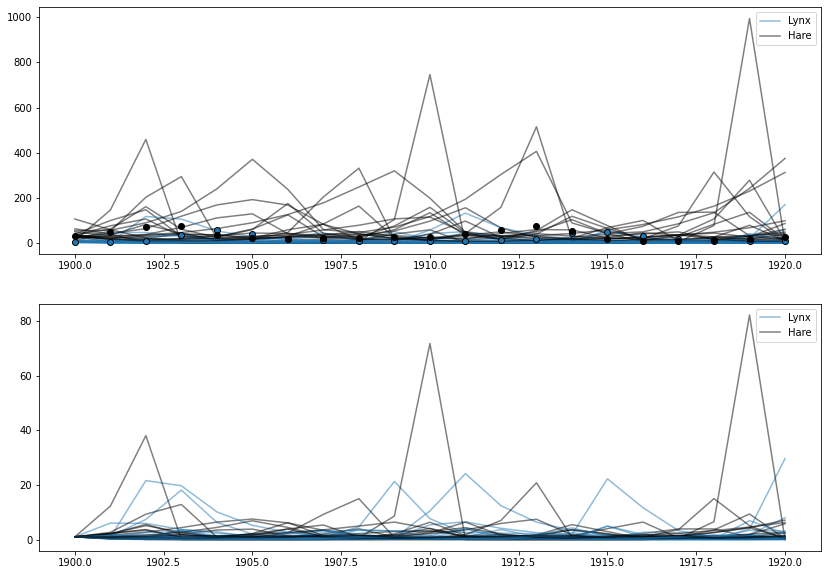

In [79]:
# plot some prior trajectories
fig, axes = plt.subplots(nrows=2, figsize=(14, 10))
idx = np.random.choice(3000, size=20, replace=False)
# cond_model = pyro.condition(model_m16_4x, data={"bL": tt(1.), "bH": tt(1.0), "mL": tt(0.7), "mH": tt(0.4)})
s = {k: v.squeeze() for k, v in Predictive(model_m16_4x, {}, num_samples=20, return_sites=("H", "L", "h", "l"))(data).items()}
# plot observed pelt trajectories
plt.sca(axes[0])
for i in range(len(idx)):
    plt.plot(data["t"], s["l"][i], color="C0", alpha=0.5)
    plt.plot(data["t"], s["h"][i], color="black", alpha=0.5)
# plot the observed data
plt.scatter(data["t"], data["lynx"], facecolor="C0", edgecolor="black", zorder=1000)
plt.scatter(data["t"], data["hare"], color="black", zorder=1000)
# plot unobserved population trajectories
plt.sca(axes[1])
for i in range(len(idx)):
    plt.plot(data["t"], s["L"][i], color="C0", alpha=0.5)
    plt.plot(data["t"], s["H"][i], color="black", alpha=0.5)
for ax in axes:
    plt.sca(ax)
    plt.plot([], [], color="C0", alpha=0.5, label="Lynx")
    plt.plot([], [], color="black", alpha=0.5, label="Hare")
    plt.legend()
plt.show()

In [80]:
m16_4x = train_nuts(
    model_m16_4x, data, 500, 3000, jit_compile=True, target_accept_prob=0.95,
    max_tree_depth=3, full_mass=True, adapt_mass_matrix=True, step_size=1e-5
)

Warmup:   0%|          | 0/3500 [00:00, ?it/s]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True, 'target_accept_prob': 0.95, 'max_tree_depth': 3, 'full_mass': True, 'step_size': 1e-05}


/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  """
/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  """
/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out 

In [82]:
m16_4x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        σH      0.22      0.04      0.22      0.17      0.28   2484.22      1.00
        σL      0.25      0.04      0.25      0.19      0.31   2467.13      1.00
        bH      0.58      0.06      0.57      0.48      0.68   2935.37      1.00
        bL      0.86      0.11      0.85      0.67      1.03   2578.15      1.00
        mH      0.19      0.03      0.18      0.13      0.24   2674.68      1.00
        mL      0.83      0.09      0.83      0.67      0.96   3189.07      1.00
        h0     34.82      2.78     34.66     30.33     39.49   2739.33      1.00
        l0      6.30      0.51      6.27      5.49      7.12   2158.34      1.00

Number of divergences: 0


This has sampled MUCH faster AND more efficiently than the previous model. We have also gained an important theoretical understanding of how the parameters are related to each other through simple dimensional analysis. The posterior predictions also look just as good as they did before. The only downside is that it's a little bit harder to interpret the hidden state, because it is some dimensionless value that you multiply an "arbitrary" dimensonful parameter by to get the observed number of pelts... kind of confusing. But this is a small price to pay for the numerical efficiency and stability we gain (seriously, it's almost 6 times faster this way)!

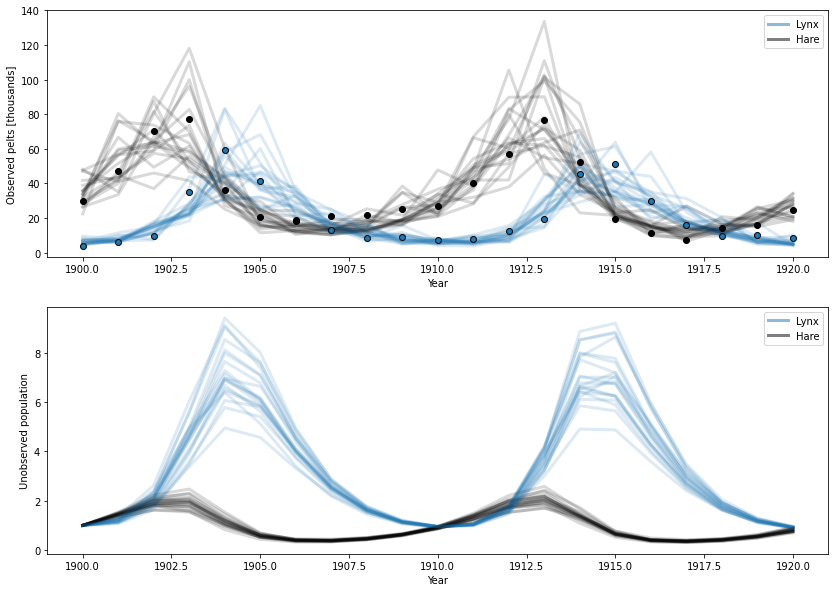

In [83]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 10))
idx = np.random.choice(1400, size=20, replace=False)
s = {k: v[:1400][idx] for k, v in m16_4x.get_samples().items()}
# cond_model = pyro.condition(model_m16_4, data={"bH": tt(1.), "mH": tt(0.05), "bL": tt(0.05), "mL": tt(1.)})
s = {k: v.squeeze() for k, v in Predictive(model_m16_4x, s, return_sites=("H", "L", "h", "l"))(data).items()}
# plot observed pelt trajectories
plt.sca(axes[0])
for i in range(len(idx)):
    plt.plot(data["t"], s["l"][i], color="C0", alpha=0.15, linewidth=3)
    plt.plot(data["t"], s["h"][i], color="black", alpha=0.15, linewidth=3)
# plot the observed data
plt.scatter(data["t"], data["lynx"], facecolor="C0", edgecolor="black", zorder=1000)
plt.scatter(data["t"], data["hare"], color="black", zorder=1000)
plt.xlabel("Year")
plt.ylabel("Observed pelts [thousands]")
# plot unobserved population trajectories
plt.sca(axes[1])
for i in range(len(idx)):
    plt.plot(data["t"], s["L"][i], color="C0", alpha=0.15, linewidth=3)
    plt.plot(data["t"], s["H"][i], color="black", alpha=0.15, linewidth=3)
for ax in axes:
    plt.sca(ax)
    plt.plot([], [], color="C0", label="Lynx", alpha=0.5, linewidth=3)
    plt.plot([], [], color="black", label="Hare", alpha=0.5, linewidth=3)
    plt.legend()
plt.xlabel("Year")
plt.ylabel("Unobserved population")
plt.show()

Despite the fact that we eliminated two parameters from the model, there is still a large degree of correlation beteween certain parameters. If we look at the pair plot below, we can see that $b_H$, $\tilde{b}_L$, $\tilde{m}_H$, and $m_L$ are all highly (anti)correlated with each other. They are also correlated with $h_0$ and $\ell_0$ as well, but to a lesser degree. However, none of these new variables shows the non-identifiability problem we saw in the previous model with ($p_H$, $H_0$) and ($p_L$, $L_0$). By non-dimensionalizing the ODE, we have vastly improved the geometry of the posterior, so that it is easier for the chains to move around and sample efficiently in this space.

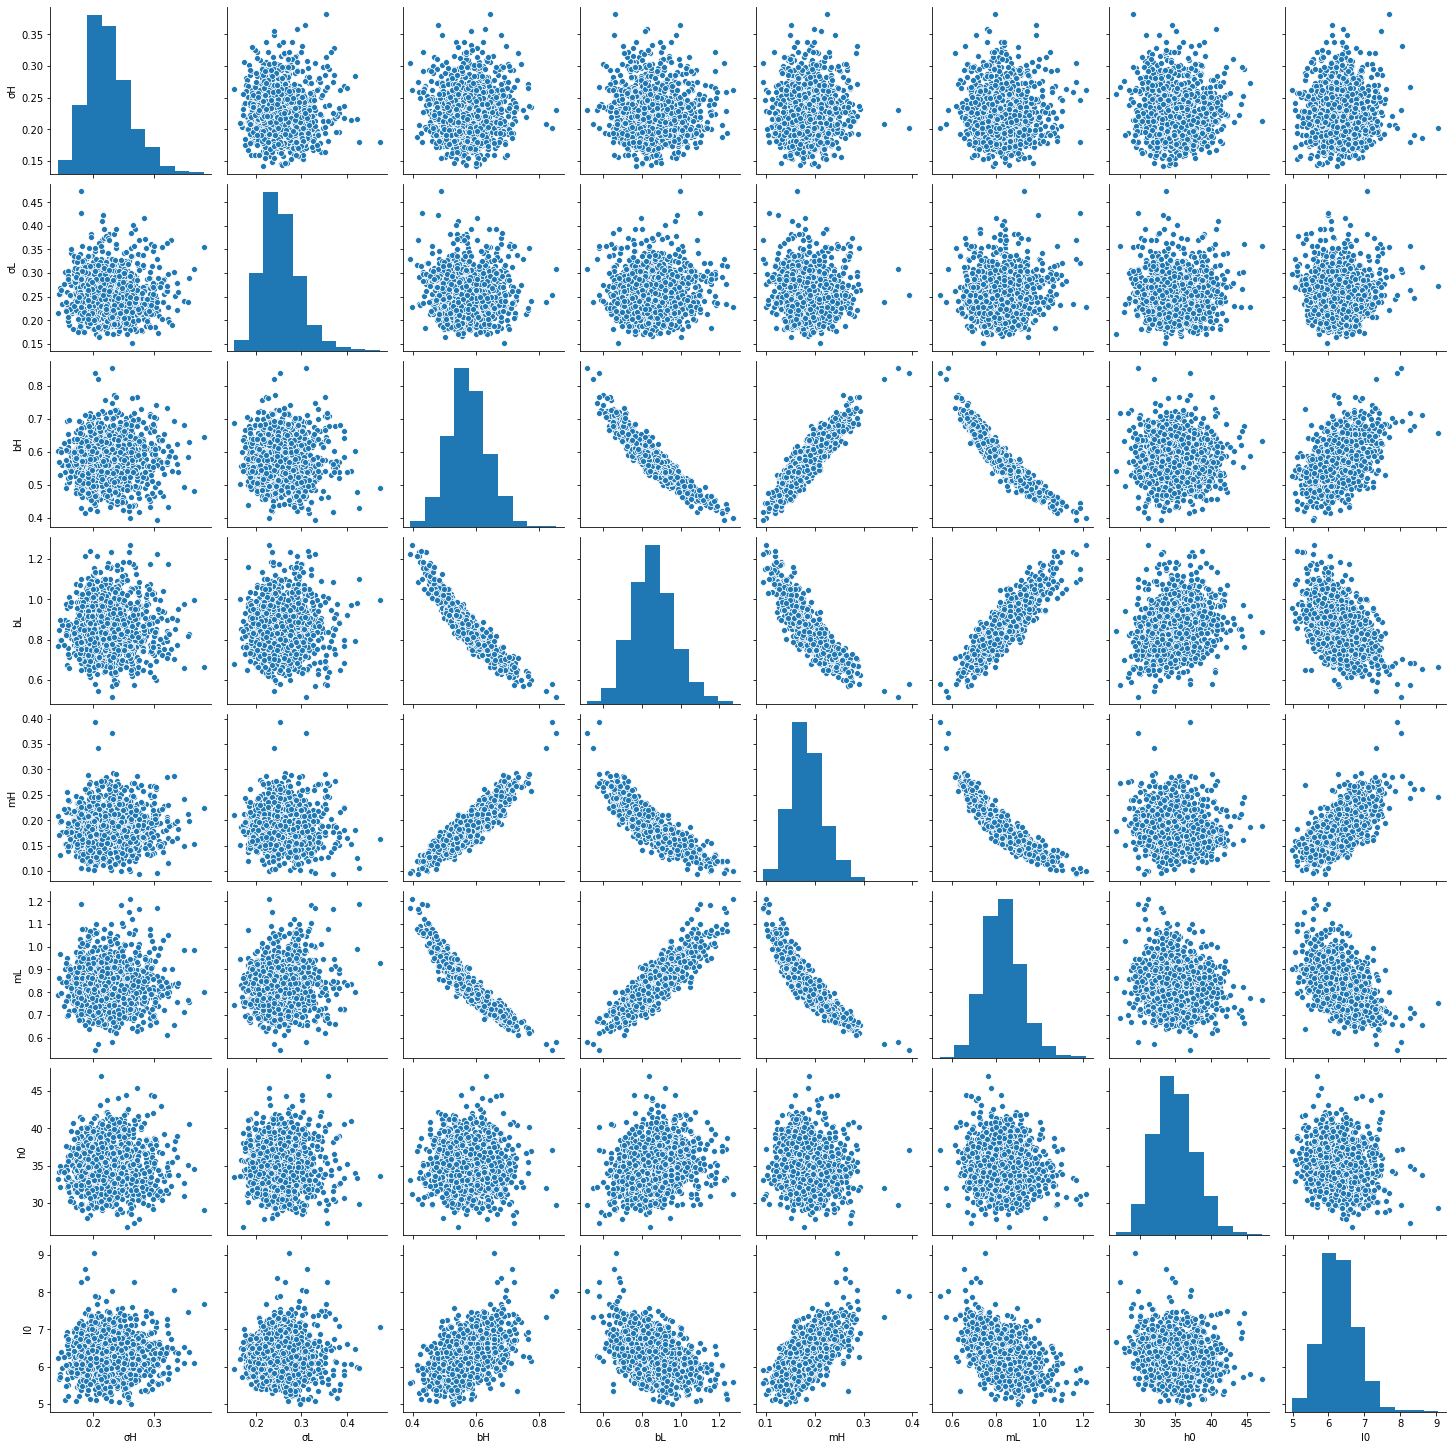

In [85]:
sns.pairplot(pd.DataFrame({k: v[:1400] for k, v in m16_4x.get_samples().items()})); plt.show()